Creo un dictionary in cui riporto tutti i modelli che andrò ad analizzare

In [20]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
#from cdo import *
from funzioni import compute_dataset_weighted
from funzioni import compute_annual_mean_weighted
from funzioni import convert_dataset_celsius
from funzioni import compute_anomaly
from funzioni import create_djf_dataset
from funzioni import compute_mean_time_season
from funzioni import compute_mean_resample_mar

In [21]:
#cdo = Cdo()

In [22]:
# creo un dizionario in cui andrò a mettere tutti i modelli dentro
models = {}

In [23]:
#Costruisco il dizionario models con il nome del modello, il nomde del percorso di tutti i file *.nc di ogni modello e il nome di .nc, cioè il modello remapbil

# percorso dei file model.txt e tos_nc_model.txt
name_models = '/work/users/guest/sbeltrami/prova/name_ocean_model.txt'
path_models = '/work/users/guest/sbeltrami/prova/path_ocean_model.txt'
path_remap_models = '/work/users/guest/sbeltrami/prova/path_remap_ocean_model.txt'
# Apro i file in modalità di lettura
with open(name_models, 'r') as file:
    # Leggo tutte le righe del file e salvo in una lista
    lines_name_models = file.readlines()
with open(path_models, 'r') as file:
    # Leggo tutte le righe del file e salvo in una lista
    lines_path_models = file.readlines()
with open(path_remap_models, 'r') as file:
    lines_path_remap_models = file.readlines()


# Itero su tutte le righe e organizzo i dati nel dizionario
for line_name, line_path, line_path_remap in zip(lines_name_models, lines_path_models, lines_path_remap_models):
    model_name = line_name.strip()

    # La chiave principale model_name deve essere presente nel dizionario
    if model_name not in models:
        models[model_name] = {}

    # Aggiungo i dati come sottochiavi
    models[model_name]['name'] = model_name
    models[model_name]['path'] = line_path.strip()
    models[model_name]['path remap'] = line_path_remap.strip()

In [24]:
models['TaiESM1'].items()

dict_items([('name', 'TaiESM1'), ('path', '/work/users/guest/sbeltrami/TaiESM1.nc'), ('path remap', '/work/users/guest/sbeltrami/TaiESM1_remapcon.nc')])

In [25]:
count = 0 #conteggio dei file che non si possono aprire
count_ok = 0 #conteggio dei file che apro

for name in models.keys():
    # Verifica se il file NetCDF esiste
    path_remap = models[name]['path remap']
    if os.path.exists(path_remap):
        # Se il file esiste, apri il dataset con xarray
        dataset = xr.open_dataset(path_remap)
        models[name]['dataset'] = dataset
        #print(f"Dataset aperto con successo per il modello {name}")
        #peso il dataset
        models[name]['dataset weighted'] = compute_dataset_weighted(dataset["tos"])
        #medie annuali con dataset pesato
        if name == 'CIESM': #da modificare!!
            print("Problema da risolvere con CIESM: ValueError: index must be monotonic for resampling")
        else:
            models[name]['dataset annual mean'] = compute_annual_mean_weighted(models[name]['dataset weighted'])
            print(models[name]['name']) 

            #Risolvi il problema con CIESM e poi metti tutto insieme
            #Seleziono il box del Nord Atlantico
            na_box = dataset.sel(lon=slice(260,360), lat=slice(30,70))
            models[name]['Nord Atlantic box'] = na_box
            #peso il dataset Nord Atlantico
            models[name]['Nord Atlantic dataset weighted'] = compute_dataset_weighted(na_box["tos"])
            #calcolo la media annuale del dataset Nord Atlantico
            models[name]['Nord Atlantic annual mean weighted'] = compute_annual_mean_weighted(models[name]['Nord Atlantic dataset weighted'])
            #Seleziono la climatologia
            na_box_climat = na_box.sel(time=slice("1984-01", "2014-12"))
            #peso il dataset del periodo scelto per la climatologia
            models[name]['Nord Atlantic climatology weighted'] = compute_dataset_weighted(na_box_climat["tos"])
            #calcolo la media annuale del dataset na sul periodo scelto
            models[name]['Nord Atlantic annual mean climatology'] = compute_annual_mean_weighted(models[name]['Nord Atlantic climatology weighted'])
            #Calcolo l'anomalia di tos rispetto alla climatologia scelta
            models[name]['Nord Atlantic anomaly'] = compute_anomaly(models[name]['Nord Atlantic annual mean weighted'],models[name]['Nord Atlantic annual mean climatology'])

        count_ok = count_ok + 1
    else:
        print(f"Errore: Il file {path_remap} non esiste per il modello {name}")

        count = count + 1

TaiESM1
AWI-CM-1-1-MR
AWI-ESM-1-1-LR
BCC-CSM2-MR
BCC-ESM1
CAMS-CSM1-0
CAS-ESM2-0
FGOALS-f3-L
FGOALS-g3
CanESM5
CMCC-CM2-SR5
ACCESS-ESM1-5
ACCESS-CM2
E3SM-1-0
E3SM-1-1
E3SM-1-1-ECA
EC-Earth3
EC-Earth3-Veg
FIO-ESM-2-0
MPI-ESM-1-2-HAM
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
MIROC6
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
GISS-E2-1-G
GISS-E2-1-G-CC
GISS-E2-1-H
CESM2
CESM2-FV2
CESM2-WACCM
CESM2-WACCM-FV2
NorCPM1
NorESM2-LM
NorESM2-MM
GFDL-CM4
GFDL-ESM4
NESM3
SAM0-UNICON
Problema da risolvere con CIESM: ValueError: index must be monotonic for resampling
MCM-UA-1-0


In [26]:
models['TaiESM1'].keys()

dict_keys(['name', 'path', 'path remap', 'dataset', 'dataset weighted', 'dataset annual mean', 'Nord Atlantic box', 'Nord Atlantic dataset weighted', 'Nord Atlantic annual mean weighted', 'Nord Atlantic climatology weighted', 'Nord Atlantic annual mean climatology', 'Nord Atlantic anomaly'])

In [27]:
len(models)

43

Nord Atlantico anomalie - Dataset ESA-CCI

Text(0.5, 0.98, 'Anomalia Nord Atlantico ESA rispetto alla media climatologica 1984 - 2014')

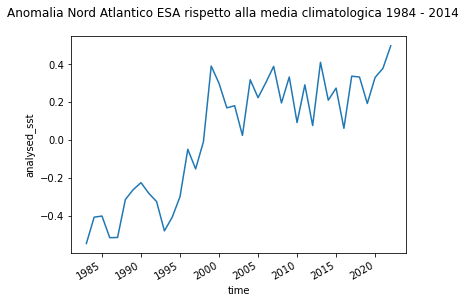

In [28]:
#ESA-CCI box Nord Atlantico
dataset_ESA_na=xr.open_dataset('/work/users/guest/sbeltrami/prova/ESA-CCI_SST_remap.nc').sel(lon=slice(260,360), lat=slice(30,70)) #seleziono lon lat del Nord Atlantico
dataset_ESA_na_celsius = convert_dataset_celsius(dataset_ESA_na["analysed_sst"]) #converto in °C
#dataset pesato
dataset_ESA_weighted_na = compute_dataset_weighted(dataset_ESA_na_celsius)
#media annuale Nord Atlantico
annual_mean_esa_na = compute_annual_mean_weighted(dataset_ESA_weighted_na)
#Scelgo periodo su cui calcolare la climatologia
esa_na_1984_2014 = dataset_ESA_na_celsius.sel(time=slice("1984-01", "2014-12"))
#peso il dataset del periodo scelto
esa_na_1984_2014_weighted = compute_dataset_weighted(esa_na_1984_2014)
#calcolo la media annuale sul periodo scelto
annual_mean_esa_na_30 = compute_annual_mean_weighted(esa_na_1984_2014_weighted)
#Calcolo l'anomalia di tos rispetto al periodo di riferimento scelto
anomaly_esa = compute_anomaly(annual_mean_esa_na,annual_mean_esa_na_30)
#plot
anomaly_esa.plot()
plt.suptitle('Anomalia Nord Atlantico ESA rispetto alla media climatologica 1984 - 2014')

Plot anomalia Nord Atlantico modelli e dataset ESA-CCI

ImportError: Plotting of arrays of cftime.datetime objects or arrays indexed by cftime.datetime objects requires the optional `nc-time-axis` (v1.2.0 or later) package.

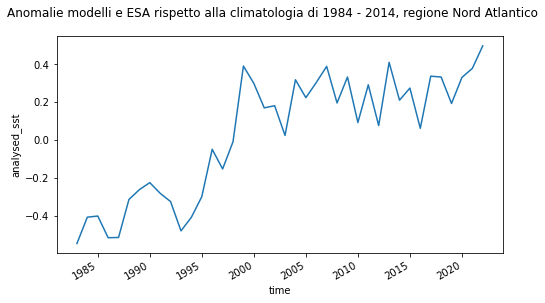

In [29]:
#Nord Atlantico
#Plot delle anomalie dei 3 modelli e di ESA su periodo di riferimento 1984-2014
fig, ax = plt.subplots(figsize=(8, 4))

# Titolo della figura
fig.suptitle('Anomalie modelli e ESA rispetto alla climatologia di 1984 - 2014, regione Nord Atlantico')

# Plot della anomalia di ESA-CCI
anomaly_esa.plot.line(x='time', label='ESA-CCI', ax=ax)

# Plot dei modelli
for name in models.keys():
    models[name]['Nord Atlantic anomaly'].plot.line(x='time', label=name, ax=ax)

# Mostra la legenda
plt.legend()

# Mostra il grafico
plt.show()


Bias : Medie stagionali (modello - osservazioni), con media climatologica delle osservazioni su periodo 1983 - 2014

Dataset ESA-CCI

In [ ]:
#Creo un dizionario in cui vado a mettere la media temporale per ogni stagione MAM, JJA, SON, DJF
esa_na_seas_mean = {}

In [ ]:
#Calcolo la media temporale su tutti e 4 i trimestri MAM = 1, JJA = 2, SON = 3, DJF = 4
for i in range(4):
    esa_na_seas_mean[i+1] = compute_mean_resample_mar(dataset_ESA_na_celsius,"1983","2014",i)

In [ ]:
esa_na_seas_mean.keys()

dict_keys([1, 2, 3, 4])

In [ ]:
models['TaiESM1'].keys()

dict_keys(['name', 'path', 'path remap', 'dataset', 'dataset weighted', 'dataset annual mean', 'Nord Atlantic box', 'Nord Atlantic dataset weighted', 'Nord Atlantic annual mean weighted', 'Nord Atlantic climatology weighted', 'Nord Atlantic annual mean climatology', 'Nord Atlantic anomaly'])

Modelli

In [ ]:
#Bias modelli
for name in models:
    if name == 'CIESM':
        print("Errore da risolvere con CIESM")
    else:
        #Seleziono il box Nord Atlantico
        na_box = models[name]['Nord Atlantic box']
        #media temporale delle stagioni MAM, JJA, SON
        for i in range(4): # ciclo su tutte le stagioni
            #Calcolo la media temporale per ogni stagione dei modelli, per un anno --> da aggiungere anni!
            model_na_seas_mean = compute_mean_resample_mar(na_box["tos"],"1984-03","1985-02",i)
            #Calcolo il bias modelli - dataset
            if (i+1) == 1: # MAM
                models[name]['Nord Atlantic bias MAM'] = model_na_seas_mean - esa_na_seas_mean[i+1]
            elif (i+1) == 2 : # JJA
                models[name]['Nord Atlantic bias MAM'] = model_na_seas_mean - esa_na_seas_mean[i+1]
            elif (i+1) == 3 : #SON
                models[name]['Nord Atlantic bias SON'] = model_na_seas_mean - esa_na_seas_mean[i+1]
            elif (i+1) == 4 : #DJF
                models[name]['Nord Atlantic bias DJF'] = model_na_seas_mean - esa_na_seas_mean[i+1]

Errore da risolvere con CIESM


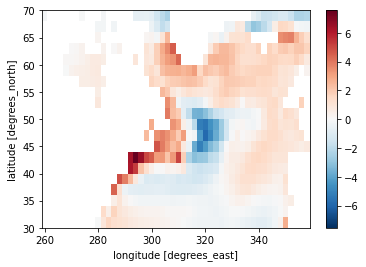

In [ ]:
models['TaiESM1']['Nord Atlantic bias DJF'].plot()

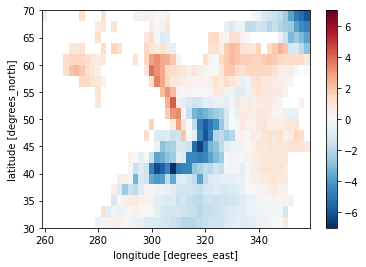

In [ ]:
models['AWI-CM-1-1-MR']['Nord Atlantic bias DJF'].plot()

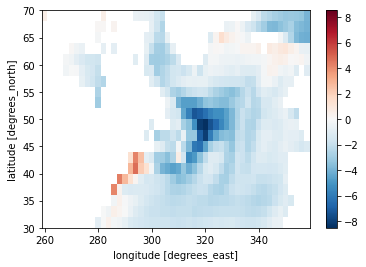

In [ ]:
models['EC-Earth3']['Nord Atlantic bias DJF'].plot()

prova con soli 3 modelli

In [ ]:
models = { 'Ec-Earth3':
                    {'path': '/work/users/guest/sbeltrami/tostest.nc',
                     },
            'IPSL-CM6A-LR':
                    {'path': '/work/users/guest/sbeltrami/tostest_ipsl.nc',
                     },
            'MPI-ESM1-2-HR':
                    {'path': '/work/users/guest/sbeltrami/tostest_mpi.nc',
                     }
         }

In [ ]:
for name in models.keys():
    #apertura modelli
    dataset = xr.open_dataset(models[name]['path'])
    #peso il dataset
    models[name]['dataset weighted'] = compute_dataset_weighted(dataset["tos"])
    #medie annuali con dataset pesato
    models[name]['annual mean'] = compute_annual_mean_weighted(models[name]['dataset weighted'])


In [ ]:
models['Ec-Earth3'].keys()

dict_keys(['path', 'dataset weighted', 'annual mean'])

In [ ]:
models['Ec-Earth3'].items()

Prova bias metodo + lungo

In [ ]:
dataset_ESA_na_celsius_period = dataset_ESA_na_celsius.sel(time=slice("1983-12","2014-11"))
#dizionario in cui metto la media temporale delle stagioni per il dataset esa
esa_na_seas_mean = {}
#Dataset ESA-CCI: calcolo della media temporale per le stagioni MAM, JJA, SON
for seas in ['MAM','JJA','SON']:
    esa_na_seas_mean[seas] = compute_mean_time_season(dataset_ESA_na_celsius_period,seas)
#Dataset ESA-CCI: seleziona dicembre dell'anno precedente e gennaio/ febbraio dell'anno successivo e calcolo la media sul tempo
esa_na_seas_mean['DJF'] = create_djf_dataset(dataset_ESA_na_celsius_period,1983).mean(dim='time')
#esa_na_seas_mean['MAM'].keys()
type(esa_na_seas_mean)
esa_na_seas_mean['DJF']

In [ ]:
#Bias modelli
for name in models:
    #Seleziono l'anno su cui voglio calcolare il bias di tos
    dataset = xr.open_dataset(models[name]['path remap'])
    #Seleziono il box del Nord Atlantico
    na_box = dataset.sel(lon=slice(260,360), lat=slice(30,70))
    period = na_box["tos"].sel(time=slice("1983-12","1984-11"))
    if name == 'CIESM':
        print("Errore da risolvere con CIESM")
    else:
        #media temporale delle stagioni MAM, JJA, SON
        for seas in ['MAM','JJA','SON']:
            model_na_seas_mean = compute_mean_time_season(period,seas)
            if seas == 'MAM':
                models[name]['Nord Atlantic bias MAM'] = model_na_seas_mean - esa_na_seas_mean[seas]
            elif seas == 'JJA':
                models[name]['Nord Atlantic bias JJA'] = model_na_seas_mean - esa_na_seas_mean[seas]
            elif seas == 'SON':
                models[name]['Nord Atlantic bias SON'] = model_na_seas_mean - esa_na_seas_mean[seas]
        #media temporale per DJF
        model_na_djf_mean = create_djf_dataset(period,1983).mean(dim='time')
        models[name]['Nord Atlantic bias DJF'] = model_na_djf_mean - esa_na_seas_mean['DJF']

